## Modelo de Identificación de Alta Conductividad en Canal de Condensados PRE

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import funciones
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix,  f1_score, precision_score, recall_score, silhouette_score

#### Carga del Dataset (Variables del Sistema de Control)

In [2]:
# Carga del Dataset
df_raw = pd.read_csv('Canal_Condensados_PRE.csv')

# Imputación de Medias por Día para Valores faltantes o con Error
df_raw = funciones.imputacion_media_dia(df_raw)

# Nombre de Variable Objetivo
canal = "Conductividad Canal Condensados PRE (uS)"

df_raw

,Nivel Vaso A1 (%),Nivel Vaso A1 (%) _STD,Nivel Vaso A2 (%),Nivel Vaso A2 (%) _STD,Nivel Vaso A3 (%),Nivel Vaso A3 (%) _STD,Nivel Vaso A4 (%),Nivel Vaso A4 (%) _STD,Nivel Vaso A5 (%),Nivel Vaso A5 (%) _STD,Nivel Vaso A6 (%),Nivel Vaso A6 (%) _STD,Nivel Vaso A7 (%),Nivel Vaso A7 (%) _STD,Nivel Vaso A8 (%),Nivel Vaso A8 (%) _STD,Nivel Vaso A9 (%),Nivel Vaso A9 (%) _STD,Conductividad Canal Condensados PRE (uS)
0,0.031247,0.007303,0.020857,0.005443,0.000000,0.000000,85.431509,0.192051,0.000000,0.000000,99.999985,0.000000,0.712131,0.217958,0.168999,0.141847,2.786714,0.012169,15.000000
1,0.032271,0.006998,0.021345,0.005411,0.000000,0.000000,85.448050,0.187367,0.000000,0.000000,99.999985,0.000000,0.695917,0.213642,0.189911,0.152112,2.788581,0.014473,15.000000
2,0.031505,0.006986,0.021262,0.005305,0.000000,0.000000,85.455451,0.184468,0.000000,0.000000,99.999985,0.000000,0.669772,0.221393,0.182132,0.143368,2.788278,0.014101,15.000000
3,0.030589,0.007123,0.021586,0.005954,0.000000,0.000000,85.444436,0.179097,0.000000,0.000000,99.999985,0.000000,0.678005,0.207590,0.175862,0.137858,2.785045,0.011671,15.000000
4,0.031497,0.007494,0.021146,0.005260,0.000000,0.000000,85.416842,0.183604,0.000009,0.000181,99.615126,0.710830,0.698450,0.218421,69.351309,42.327807,27.994591,40.620843,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,37.182920,13.437065,56.224971,2.362391,48.141849,2.762350,39.782778,1.307873,31.076178,2.120877,34.998127,4.270226,28.945617,2.761690,24.702373,2.529367,7.983522,25.147984,40.861548
1183,42.925893,2.268081,56.200794,3.066094,48.631729,3.899252,39.995591,0.412918,30.199167,1.503721,32.464125,4.199976,27.978978,3.518760,23.477413,2.422733,0.636667,0.012685,37.674048
1184,42.272657,0.983198,58.590219,2.241646,47.219586,3.054005,39.979806,0.341479,30.160907,0.501709,35.623855,1.824317,29.985877,0.434474,24.954949,1.418305,12.213477,25.441039,36.436757
1185,40.479558,2.140981,57.496650,2.226698,50.020351,2.553000,40.019065,0.379514,30.359847,1.968595,33.730622,3.898266,27.871952,3.499252,23.924261,2.748835,15.595673,24.984656,35.150443


### Tratamiento de Outliers y Distribución de Frecuencias de Valores de Conductividad

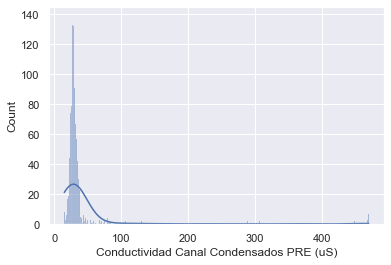

 Estadísticas de Conductividad: 


count    1115.000000
mean       50.740722
std        79.574039
min        15.068860
25%        26.183892
50%        28.963041
75%        33.191245
max       469.976515
Name: Conductividad Canal Condensados PRE (uS), dtype: float64

In [3]:
# Dataset
df = df_raw.copy()

# Porcentaje en Colas
porcentaje_outliers = 0

# Remoción de Outliers
q_low = df[canal].quantile(porcentaje_outliers/100)
q_hi  = df[canal].quantile(1 - porcentaje_outliers/100)
df = df[(df[canal] < q_hi) & (df[canal] > q_low)]

# CDF
sns.set(style="darkgrid")
sns.histplot(data=df, x=canal, kde=True)
plt.show()

# Estadística Descriptiva
print("\033[1m Estadísticas de Conductividad: \033[0m")
df[canal].describe()


### Determinación de Umbral Óptimo

Se aplica una **binarización** a la variable de conductividad. La binarización consiste en *transformar* la variable continua de conductividad a una variable binaria de *presencia* o *no presencia* de conductividad. Esto porque no toda conductividad se debe necesariamente a trazas de azúcar, y en la práctica es más útil definir un límite superior para esta variable. 

La binarización se implementa de forma que: Una **alta conductividad es una clase POSITIVA** y una **baja conductividad es una clase NEGATIVA**.

Adicionalmente, debido a la distribución *sesgada* de la variable de conductividad, es posible que una mala selección del umbral produzca un imbalance en el conjunto de entrenamiento y por lo tanto, métricas de detección del algoritmo que no son óptimas.

#### K-Means Clustering
Para poder distinguir entre clases, se ejecuta un algoritmo de clustering no-supervisado, con el propósito de encontrar **"regiones de operación"** en los datos, y luego verificar si estas regiones tienen en común algún rango de valores de conductividad.

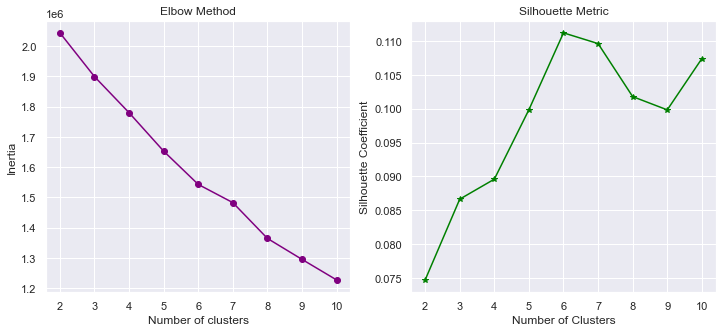

In [4]:
funciones.exploracion_clusters(df,canal)

Puede observarse que **las métricas de cohesión son más altas para 6 agrupaciones**. Se forman los 6 grupos utilizando el algoritmo K-Means, con n=6. Luego, se grafica la serie de tiempo de la conductividad durante la zafra y se colorean las regiones encontradas.

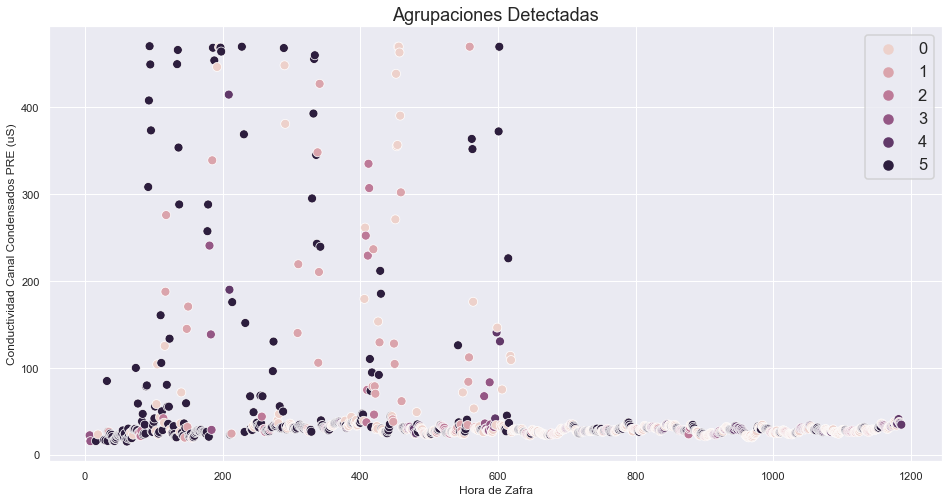

,Nivel Vaso A1 (%),Nivel Vaso A1 (%) _STD,Nivel Vaso A2 (%),Nivel Vaso A2 (%) _STD,Nivel Vaso A3 (%),Nivel Vaso A3 (%) _STD,Nivel Vaso A4 (%),Nivel Vaso A4 (%) _STD,Nivel Vaso A5 (%),Nivel Vaso A5 (%) _STD,Nivel Vaso A6 (%),Nivel Vaso A6 (%) _STD,Nivel Vaso A7 (%),Nivel Vaso A7 (%) _STD,Nivel Vaso A8 (%),Nivel Vaso A8 (%) _STD,Nivel Vaso A9 (%),Nivel Vaso A9 (%) _STD,Conductividad Canal Condensados PRE (uS)
group,,,,,,,,,,,,,,,,,,,
0,37.356828,4.285921,43.916031,4.400266,44.929775,5.286450,43.591056,4.857653,30.627787,5.013334,24.091710,2.632132,22.971763,2.339221,23.865541,2.936155,26.767289,1.862274,42.242436
1,38.781925,5.467347,39.036630,4.169959,40.691762,5.987947,39.551027,5.604807,30.519497,5.528020,29.828639,6.193801,22.694201,3.952312,52.670087,20.840073,30.378585,4.006788,69.147991
2,30.264203,2.440239,31.974942,3.077923,38.596409,2.061067,35.683641,2.720976,23.864298,2.174793,23.787786,2.321414,59.584176,25.857516,23.886834,2.647549,26.096722,2.104774,44.829369
3,33.669613,1.824681,41.783063,1.833449,38.552942,2.540456,42.393911,2.147256,26.907838,2.913837,66.320400,22.985620,23.268416,2.628871,27.587089,3.635410,29.995749,1.898029,36.238457
4,26.600489,3.590560,41.735260,2.168217,41.114810,2.514913,38.129007,2.170398,29.520293,3.533276,25.091692,3.946991,24.409480,2.281561,26.454833,3.332365,38.818306,31.291531,43.121012
5,26.158218,2.328939,26.772457,1.757649,27.658803,2.034805,30.140604,2.321934,24.035794,2.275057,22.923078,2.058331,19.322111,1.787874,22.523582,2.277457,23.501912,1.515507,58.743299


 Medias por Agrupación: 
 Desviaciones Estándar por Agrupación: 


,Nivel Vaso A1 (%),Nivel Vaso A1 (%) _STD,Nivel Vaso A2 (%),Nivel Vaso A2 (%) _STD,Nivel Vaso A3 (%),Nivel Vaso A3 (%) _STD,Nivel Vaso A4 (%),Nivel Vaso A4 (%) _STD,Nivel Vaso A5 (%),Nivel Vaso A5 (%) _STD,Nivel Vaso A6 (%),Nivel Vaso A6 (%) _STD,Nivel Vaso A7 (%),Nivel Vaso A7 (%) _STD,Nivel Vaso A8 (%),Nivel Vaso A8 (%) _STD,Nivel Vaso A9 (%),Nivel Vaso A9 (%) _STD,Conductividad Canal Condensados PRE (uS)
group,,,,,,,,,,,,,,,,,,,
0,9.480714,7.716892,13.681403,8.304161,15.688302,9.693490,13.874640,8.540845,16.277348,9.889670,7.608808,2.509286,5.873819,1.638129,6.915711,3.251827,10.872169,1.971676,65.033126
1,8.776214,5.714108,12.134316,4.328518,10.748457,6.372224,12.041372,6.977844,8.924197,4.792052,7.631583,5.790510,7.458975,2.630981,25.769497,14.212751,6.276617,3.057521,98.007383
2,9.537320,3.440413,18.300960,5.820364,11.423201,1.521037,9.091980,5.147203,7.041074,1.731920,3.766893,1.635409,31.326726,17.440016,3.756860,2.215566,3.821096,2.642734,62.688231
3,7.685530,1.358474,11.986287,1.370685,11.271962,2.507624,9.282694,1.813219,6.101524,2.453790,31.022767,17.801583,5.264481,1.519806,12.522889,3.115686,12.508248,1.177705,31.281896
4,13.468322,5.301219,9.082259,1.666858,6.302477,1.581070,8.055449,1.595691,10.677115,6.317707,7.364542,5.622360,4.048137,1.458529,5.127623,3.273974,20.919039,7.954537,54.730373
5,12.870214,3.613784,15.201622,2.928233,15.883061,3.194190,13.030167,3.115484,9.186585,3.672388,5.397104,1.834103,7.731712,2.176131,6.588621,2.551057,8.802381,1.685543,95.043464


In [5]:
funciones.clustering(df,canal,6)

Puede observarse que las agrupaciones 0 y 1 comparten tendencias de conductividad bajas. Existe un valor de aproximadamente 250 a 300 uS de conductividad en estas regiones estables.

Para explorar este umbral de conductividad, se implementa un algoritmo que explora *distintos umbrales de conductividad* y grafica las métricas de entrenamiento para cada selección:

- **Precision:** Habilidad de Clasificador de minimizar Falsos Positivos.
- **Accuracy:** Habilidad del Clasificador de Detectar Verdaderos Positivos y Verdaderos Negativos.
- **Recall:** Habilidad del Clasificador de Detectar Verdaderos Positivos.
- **F1:** Media Ponderada de la Precision y el Recall.
- **Overall:** Media Aritmética de todas las métricas anteriores.


De esta forma, se obtiene una **propuesta de umbral óptima**.

,Precision,Accuracy,F1,Recall,Overall
Umbral Conductividad,,,,,
20.0,0.970328,0.982090,0.990964,0.996970,0.985088
30.0,0.592406,0.608955,0.417778,0.353383,0.493131
40.0,0.777114,0.856716,0.040000,0.022222,0.424013
50.0,0.829911,0.886567,0.050000,0.027027,0.448376
60.0,0.796336,0.889552,0.000000,0.000000,0.421472


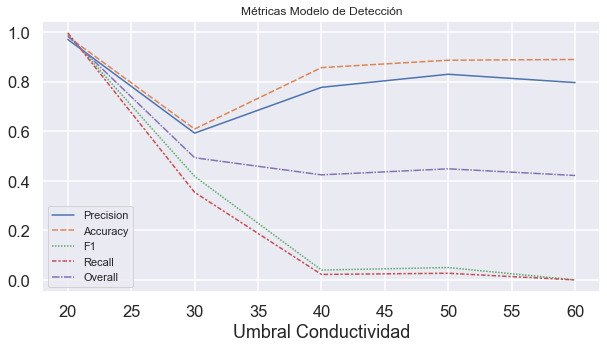

In [6]:
funciones.busqueda_umbral(df,canal,[20,30,40,50,60])

#### Selección de Umbral
El criterio para seleccionar el umbral se propone sea el del **"cima"**. En este método se selecciona un umbral a partir del cual las métricas caen por debajo de un nivel "aceptable".

Por ejemplo, una conductividad de 25 nos proporciona suficiente rango y además las métricas están arriba del 80%.


### Entrenamiento Modelo de Clasificación
Basado en los resultados anteriores, se selecciona un umbral y se entrena el modelo de detección.

In [7]:
# Umbral de Detección
umbral_final = 25

# Binarización y construcción del Dataset de Entrenamiento y Validación
X = df.drop(canal, axis=1)
y = df[canal].apply(lambda x: 1 if x > umbral_final else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123456)

In [8]:
# Estandarización y Entrenamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = LogisticRegression()
model.fit(X_train, y_train)
coefficients = model.coef_[0]

### Métricas Finales de Entrenamiento y Matriz de Confusión
Se muestran las métricas del modelo final y su desempeño para detectar Verdaderos Positivos, Verdaderos Negativos, Falsos Positivos y Falsos Negativos.

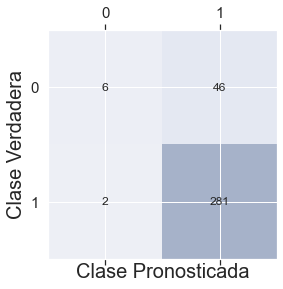

In [9]:
y_pred = model.predict(X_test)

conf_mat = funciones.matriz_confusion(y_test,y_pred)

In [10]:
funciones.metricas_finales(y_test,y_pred,umbral_final)

,Umbral Conductividad,Precision (%),Accuracy (%),F1 (%),Recall (%),Overall (%)
0,25.0,84.235702,85.671642,92.131148,99.293286,90.332944


### Factores de Importancia
Para la determinación de los factores de importancia se presentan dos perspectivas: Importancia por Magnitud del Factor e Importancia por Control del Factor.

#### Importancia por Magnitud del Factor
Esta importancia es el peso relativo que tiene este factor respecto a los demás factores, para contribuir positivamente o negativamente a la conductividad.
Si la contribución es positiva, a mayor magnitud del factor, mayor probabilidad de detectar la clase positiva (mayor probabilidad de alta conductividad).
Si la contribución es negativa, a mayor magnitud del factor, mayor probabilidad de detectar la clase negativa (menor probabilidad de alta conductividad).

<AxesSubplot:ylabel='Variable'>

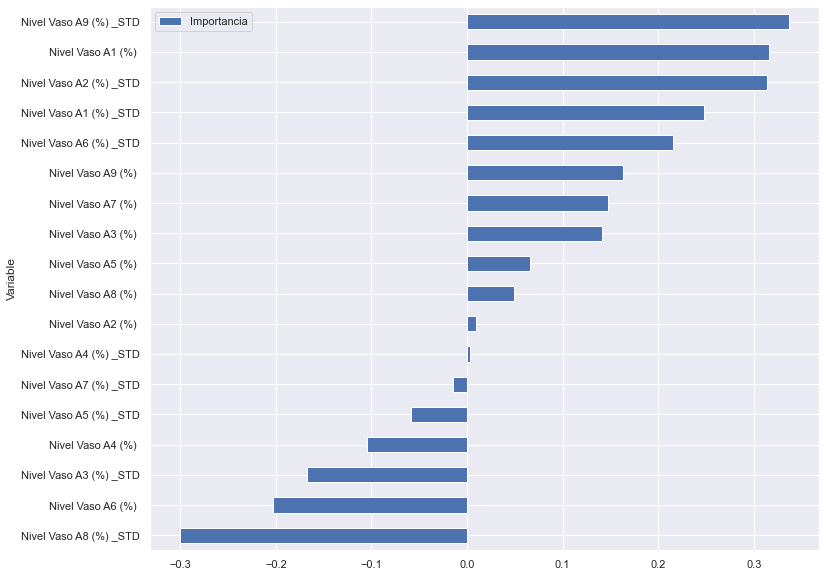

In [11]:
feature_importance = pd.DataFrame({'Variable': X.columns, 'Importancia': coefficients})
feature_importance = feature_importance.sort_values('Importancia', ascending=True)
feature_importance.plot(x='Variable', y='Importancia', kind='barh', figsize=(12, 10))

#### Importancia por Control del Factor
Esta importancia se calcula a partir del efecto que tiene aleatorizar la variable (manteniendo todas las demás constantes) sobre la conductividad. Esto es especialmente importante para identificar **el efecto que tiene la precisión del control de la variable sobre la conductividad final**.

Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

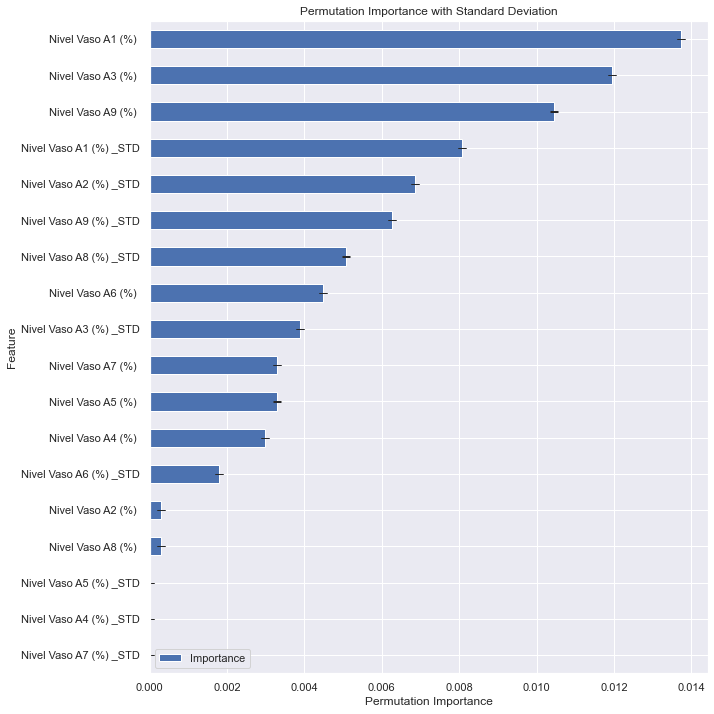

In [12]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)


feature_importance = pd.DataFrame({'Feature': X.columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 12), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')

### Conclusiones:
Dados los factores de importancia identificados, las recomendaciones son como sigue:
- Para los **factores con mayor importancia por magnitud** se recomienda controlar con un **SP menor** (si la importancia por magnitud es **positiva**) o con un **SP mayor** (si la importancia por magnitud es **negativa**) para *reducir la conductividad*.
- Para los **factores con mayor importancia por control** se recomienda **reducir la varianza de la variable** (reducir su variación si es posible por medios manuales o ajustes de los lazos de control involucrados). En el caso de *importancias negativas*, significa que los algoritmos *no encontraron evidencia de que el control de esta variable importe para la conductividad*.